In [1]:
!pip install -U scikit-learn
!pip install scikeras[tensorflow]
!pip install pandas
!pip install tensorflow
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 27.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 3.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 30.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.0 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.1

In [ ]:
#Restart kernel after install
import os
os._exit(00)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
import wfdb
import random
import datetime
import time
import itertools

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import BatchNormalization

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from operator import itemgetter

2023-03-16 16:32:44.459006: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 16:32:44.578383: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

startdir = os.getcwd()
print(startdir)
#os.chdir(startdir)


/work/ECG_masters


In [5]:
os.chdir(startdir)
print(os.getcwd())

/work/ECG_masters


In [4]:
def setup():

    try:
        del X
        del y
        del ids
        del X_test
        del X_train
        del y_test
        del y_train
        del df_id
        del df_x
        del df_y
        print('Clear previously loaded data.')
    except:
       pass

    X = np.load("X.npy")
    y = np.load("y.npy")
    ids = np.load("ids.npy")

    #confirm that arrays are same length
    print(np.shape(ids))   
    print(np.shape(X))
    print(np.shape(y))

    # reshape input to be [samples, time steps, features = 1]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, ids

In [ ]:
#oneHotEncode y
print(y[1:10])
encoder = OneHotEncoder(handle_unknown='ignore')
y = encoder.fit_transform(y).toarray()

#transform y to int

print(y.dtype)
y = np.rint(y).astype(int)
print(y.dtype)
print(y[1:10])

#confirm that arrays are same length
print(np.shape(ids))   
print(np.shape(X))
print(np.shape(y))

# reshape input to be [samples, time steps, features = 1]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [4]:
from matplotlib import pyplot

def losscurve(historyv, name='losscurve'):
    loss = historyv.history['loss']
    val_loss = historyv.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(name)
    plt.legend()
    
    plt.show()

    
def acccurve(historyv, name='acccurve'):
    acc = historyv.history['accuracy']
    val_acc = historyv.history['val_accuracy']
    loss = historyv.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name)
    plt.show()

def ROC_curve(test, pred_pr, name='ROC_curve'):
    auc = roc_auc_score(test, pred_pr)
    fpr, tpr, thresholds = roc_curve(test, pred_pr)
    
    plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=3) # dashed line with black(k) color

    plt.plot(fpr, tpr, label='AUC = %0.4f' % auc, linewidth=3)

    plt.xlabel('False positive rate', fontsize=18)
    plt.ylabel('True positive rate', fontsize=18)
    plt.ylabel('True positive rate', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('ROC curve', fontsize=18)
    plt.legend(loc='best', fontsize=18)
    plt.savefig(name)
    plt.show()

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.savefig('results/'+title)
    plt.show()

In [6]:
def evaluate(X_test,y_test, model, modelname,time):
    #acc = model.score(X_test, y_test)
    #results = model.evaluate(X_test, y_test)
    #acc_r = results[1]
    #print(acc_r)
    y_pred_pr = model.predict(X_test)
    y_pred_cl = np.argmax(y_pred_pr, axis=1)
    print(y_pred_pr[:10])
    print('using probability for having AFIB') 
    y_pred_pr = y_pred_pr[:,1]
    print(y_pred_pr[:10])
   
    print('y_pred_cl')
    print(y_pred_cl[:10])   
    #y_pred = np.argmax(y_pred, axis=1)
    
    print(y_test[:10]) 
    y_test = np.argmax(y_test, axis=1)
    print('y_test')
    print(y_test[:10]) 
    
    tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_pred_cl), labels=[0, 1]).ravel()
    cm = confusion_matrix(list(y_test), list(y_pred_cl), labels=[0, 1])
    #Sensitivity/Recall/TPR
    tpr= tp/(fn+tp)
    #Specificity/TNR
    tnr = tn/(tn+fp)
    #Precision/Positive Predictive value
    prec = tp/(tp+fp)
    #FPR
    fpr = fp/(tn+fp)
    #Accuracy
    acc = (tp+tn)/(tp+tn+fp+fn)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_pr)
        ROC_curve(y_test, y_pred_pr, name='results/ROC_curve')
    except ValueError:
        #pass
        roc_auc = 2    
    
    plot_confusion_matrix(cm, classes=['Normal','AFIB'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    
    f1 = f1_score(y_test, y_pred_cl)

    toappend = pd.DataFrame({'model': [modelname] ,'acc':[acc], 'tpr':[tpr], 'tnr':[tnr], 'prec':[prec],'fpr':[fpr], 'roc_auc':[roc_auc], 'f1':[f1], 'time': [time]}, 
                           columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1', 'time'])
    
    return toappend


In [8]:

def split_train_eval(model):

    metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
                        columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])

    gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
    
    for train_index, test_index in gss.split(X, y, ids):
    
        X_train = np.array(list(itemgetter(*train_index)(X)))
        X_test = np.array(list(itemgetter(*test_index)(X)))
        y_train = np.array(list(itemgetter(*train_index)(y)))
        y_test = np.array(list(itemgetter(*test_index)(y)))

        print(f"shape of x_train: {np.shape(X_train)}, type: {type(X_train)}")
        print(f"shape of x_test: {np.shape(X_test)}, type: {type(X_test)}")
        
        
        if (len(X_train)+len(X_test) != len(X)):
            raise TypeError("train and test sets dont add up!")
        
        #get time for start of training. Used in evaluate()
        start = time.time()
        
        model.compile(loss='binary_crossentropy',
            optimizer='adam', metrics = ['accuracy','Precision','Recall'])

        history = model.fit(X_train, y_train,    
                    epochs=20,
                    batch_size = 64,
                    validation_data=(X_test, y_test),
                    verbose=1)
        print("fitted")
        timeToFit =  time.time()-start

        toappend = evaluate(X_test,y_test, model, "combo", timeToFit)

        metrics = pd.concat([metrics, toappend])
        print("appended metrics")

        losscurve(history)
        acccurve(history)
        metrics.to_pickle('metrics.pkl')


In [ ]:
#pathlist = []
pathlist = ['2','4','6','8','10','12','20','30','40']

for path in pathlist:
    os.chdir(startdir+'/data/afdb/ol5_win'+path)
    print(os.getcwd())
    X, y, ids = setup()
    
    #workaround to be able to declare model prior to splitting data like in LOGO or CV.
    X_train = np.zeros((3, X.shape[1],1))


    combo = keras.models.Sequential([
    keras.layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu',
                        input_shape=[X_train.shape[1], X_train.shape[2]],name='conv1'),
    keras.layers.BatchNormalization(name='batch1'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool1'),
    keras.layers.Conv1D(filters = 64 , kernel_size = 5, activation = 'relu',name='conv2'),
    keras.layers.BatchNormalization(name='batch2'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool2'),
    keras.layers.Conv1D(filters = 32 , kernel_size = 5, activation = 'relu',name='conv3'),
    keras.layers.BatchNormalization(name='batch3'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool3' ),
    keras.layers.LSTM(64, return_sequences=False, name='LSTM'), 
    keras.layers.Dense(128,  name='dense_1'),
    keras.layers.Dense(2, activation='sigmoid', name='dense_2'),
    
    ])
                              
    combo.summary()

    split_train_eval(combo)
   
    

In [ ]:
#pathlist = ['1','2','3', '4','5','6','7','8','9']
pathlist = ['9']

for path in pathlist:
    os.chdir(startdir+'/data/afdb/flt_ol'+path+'_win8')
    print(os.getcwd())
    X, y, ids = setup()
    
    #workaround to be able to declare model prior to splitting data like in LOGO or CV.
    X_train = np.zeros((3, X.shape[1],1))


    combo = keras.models.Sequential([
    keras.layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu',
                        input_shape=[X_train.shape[1], X_train.shape[2]],name='conv1'),
    keras.layers.BatchNormalization(name='batch1'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool1'),
    keras.layers.Conv1D(filters = 64 , kernel_size = 5, activation = 'relu',name='conv2'),
    keras.layers.BatchNormalization(name='batch2'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool2'),
    keras.layers.Conv1D(filters = 32 , kernel_size = 5, activation = 'relu',name='conv3'),
    keras.layers.BatchNormalization(name='batch3'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool3' ),
    keras.layers.LSTM(64, return_sequences=False, name='LSTM'), 
    keras.layers.Dense(128,  name='dense_1'),
    keras.layers.Dense(2, activation='sigmoid', name='dense_2'),
    
    ])
                              
    combo.summary()

    split_train_eval(combo)
   
    

In [13]:
metrics

NameError: name 'metrics' is not defined

In [7]:
def logoloop(model):

    metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
                        columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])
    history = []
    
    logo = LeaveOneGroupOut()
    logo.get_n_splits(groups=ids)

    for train_index, test_index in logo.split(X, y, ids):
        #print(datetime.datetime.now())
        
        X_train = np.array(list(itemgetter(*train_index)(X)))
        X_test = np.array(list(itemgetter(*test_index)(X)))
        y_train = np.array(list(itemgetter(*train_index)(y)))
        y_test = np.array(list(itemgetter(*test_index)(y)))

        #y_train_all.append(y_train)
        #y_test_all.append(y_test)
        print(X_train.shape)
        print(y_train.shape)
        print(f"shape of y: {np.shape(y_train)}, type of y: {type(y_train)}")
        print(f"shape of x: {np.shape(X_train)}, type of y: {type(y_train)}")

        #Changing name of model to ID of test-individual
        testID =  np.array(list(itemgetter(*test_index)(ids)))[0]
        
        #get time for start of training. Used in evaluate()
        start = time.time()
        
        history = model.fit(X_train, y_train,    
                    epochs=25,
                    batch_size = 64,
                    validation_data=(X_test, y_test),
                    verbose=1)
        print("fitted")
        
       

        timeToFit =  time.time()-start
        toappend = evaluate(X_test,y_test, model, testID , timeToFit)


        metrics = pd.concat([metrics, toappend])
        print("appended metrics")
        

    
    losscurve(history,'results/logo_loss' )
    acccurve(history,'results/logo_acc')
    metrics.to_pickle('results/logo_metrics.pkl')
    
    

In [1]:
def gkf_loop():

    metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
                        columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])

    gkf = GroupKFold(n_splits=5)

    
    gkf.get_n_splits(groups=ids)

    for train_index, test_index in gkf.split(X, y, ids):
        print(datetime.datetime.now())
        
        X_train = np.array(list(itemgetter(*train_index)(X)))
        X_test = np.array(list(itemgetter(*test_index)(X)))
        y_train = np.array(list(itemgetter(*train_index)(y)))
        y_test = np.array(list(itemgetter(*test_index)(y)))
        
        
        print(X_train.shape)
        print(X_test.shape)
        print(f"shape of y: {np.shape(y_train)}, type of y: {type(y_train)}")
        print(f"shape of x: {np.shape(X_train)}, type of y: {type(y_train)}")
        
        start = time.time()
        combo.compile(loss='binary_crossentropy',
            optimizer='adam', metrics = ['accuracy','Precision','Recall'])

        history = combo.fit(X_train, y_train,    
                    epochs=20,
                    batch_size = 128,
                    validation_data=(X_test, y_test),
                    verbose=1)
        print("fitted")

        timeToFit =  time.time()-start

        toappend = evaluate(X_test,y_test, model, "combo", timeToFit)

        metrics = pd.concat([metrics, toappend])
        print("appended metrics")
        
    
    losscurve(history)
    acccurve(history)
    metrics.to_pickle(metrics.pkl')
    

## LOGO using best model after tuning. Excluding id=22 to compare w/ Masud's results

In [8]:
path="./data/afdb/ol5_win12/" 
X = np.load(path+"X.npy")
y = np.load(path+"y.npy")
ids = np.load(path+"ids.npy")

#confirm that arrays are same length
print(np.shape(ids))   
print(np.shape(X))
print(np.shape(y))

# exclude id=22

index22 = np.where( ids == '08434')
print(index22)
newX = np.delete(X, index22,0)
newy = np.delete(y, index22,0)
newids = np.delete(ids, index22)

print(np.shape(newids))   
print(np.shape(newX))
print(np.shape(newy))

X = newX
y = newy
ids = newids

# reshape input to be [samples, time steps, features = 1]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(np.shape(X))

(128044,)
(128044, 3000)
(128044, 2)
(array([10720, 10721, 10722, ..., 16338, 16339, 16340]),)
(122423,)
(122423, 3000)
(122423, 2)
(122423, 3000, 1)


(array([10720, 10721, 10722, ..., 16338, 16339, 16340]),)
(122423,)
(122423, 3000)
(122423, 2)


In [9]:
#declare model w/ best params from hyperparamsearch
def buildBest1603():
    combo_input = keras.Input(shape=(X.shape[1], X.shape[2]), name='ecg_segment')

    i = layers.Conv1D(
        filters = 32,
        #tuning kernel size layer 1
        kernel_size=7,
        activation = 'relu',name='conv1')(combo_input)
    i = layers.BatchNormalization(name='batch1')(i)
    i = layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool1')(i)
    i = layers.Conv1D(
        filters = 64 , 
        #tuning kernel size layer 2
        kernel_size=11,
        #kernel_size = 5,
        activation = 'relu',name='conv2')(i)
    i = layers.BatchNormalization(name='batch2')(i)
    i = layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool2')(i)
    i = layers.Conv1D(
        filters = 32 ,
        #tuning kernel size layer 3
        kernel_size=5,
        activation = 'relu',name='conv3')(i)

    i = layers.BatchNormalization(name='batch3')(i)
    i = layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool3')(i)
    i = layers.LSTM(64, return_sequences=False, name='LSTM')(i) 
    i = layers.Dense(128,  name='dense_1')(i)
    combo_output = layers.Dense(2, activation='sigmoid', name='dense_2')(i)

    combo = keras.Model(combo_input, combo_output, name="combo")
    combo.summary()
    #tuning learning_rate
    learning_rate = 0.003221571067416636
    combo.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics = ['accuracy'])
    return combo


2023-03-16 16:33:50.000635: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 16:33:50.099541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


Model: "combo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_segment (InputLayer)    [(None, 3000, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, 2994, 32)          256       
                                                                 
 batch1 (BatchNormalization)  (None, 2994, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 1497, 32)          0         
                                                                 
 conv2 (Conv1D)              (None, 1487, 64)          22592     
                                                                 
 batch2 (BatchNormalization)  (None, 1487, 64)         256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 744, 64)           0     

2023-03-16 16:33:55.935008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-16 16:33:56.165228: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd9f0893320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-16 16:33:56.165266: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-16 16:33:56.174315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-16 16:33:56.327428: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1827/1827 [==============================] - 71s 37ms/step - loss: 0.2536 - accuracy: 0.9019 - val_loss: 0.1048 - val_accuracy: 0.9724
Epoch 2/25
1827/1827 [==============================] - 67s 37ms/step - loss: 0.1666 - accuracy: 0.9361 - val_loss: 0.3646 - val_accuracy: 0.8455
Epoch 3/25
1827/1827 [==============================] - 67s 36ms/step - loss: 0.0629 - accuracy: 0.9807 - val_loss: 0.1098 - val_accuracy: 0.9709
Epoch 4/25
1827/1827 [==============================] - 66s 36ms/step - loss: 0.0407 - accuracy: 0.9882 - val_loss: 0.0824 - val_accuracy: 0.9745
Epoch 5/25
1827/1827 [==============================] - 66s 36ms/step - loss: 0.0442 - accuracy: 0.9871 - val_loss: 0.1442 - val_accuracy: 0.9657
Epoch 6/25
1827/1827 [==============================] - 68s 37ms/step - loss: 0.0419 - accuracy: 0.9882 - val_loss: 0.3367 - val_accuracy: 0.8978
Epoch 7/25
1827/1827 [==============================] - 66s 36ms/step - loss: 0.0319 - accuracy: 0.9907 - val_loss: 0.0923 - val_accura

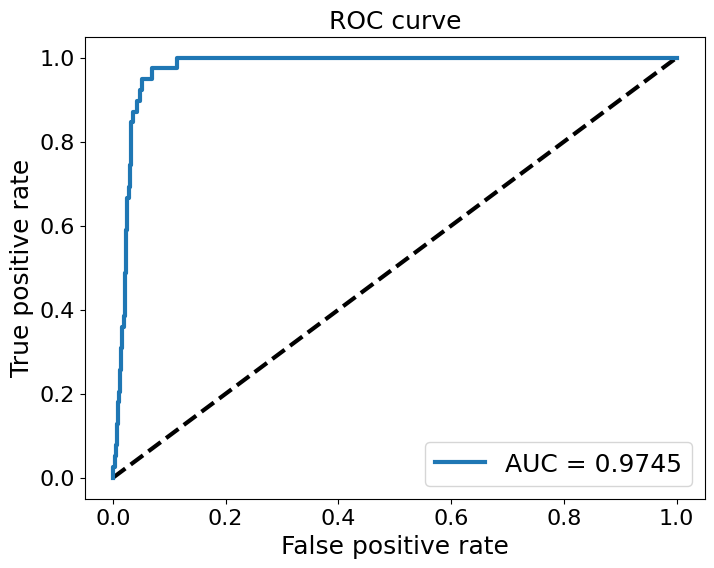

Confusion matrix, without normalization
[[5232  269]
 [   3   36]]


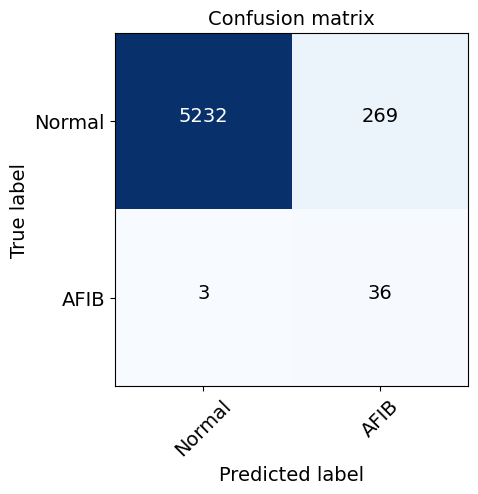

appended metrics
(116702, 3000, 1)
(116702, 2)
shape of y: (116702, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116702, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1824/1824 [==============================] - 66s 36ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0625 - val_accuracy: 0.9761
Epoch 2/25
1824/1824 [==============================] - 66s 36ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0831 - val_accuracy: 0.9650
Epoch 3/25
1824/1824 [==============================] - 66s 36ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.0609 - val_accuracy: 0.9769
Epoch 4/25
1824/1824 [==============================] - 66s 36ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0421 - val_accuracy: 0.9839
Epoch 5/25
1824/1824 [==============================] - 56s 30ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.0757 - val_accuracy: 0.9752
Epoch 6/25
1824/1824 [==============================] - 63s 35ms/step - loss: 0.0143 - accuracy: 

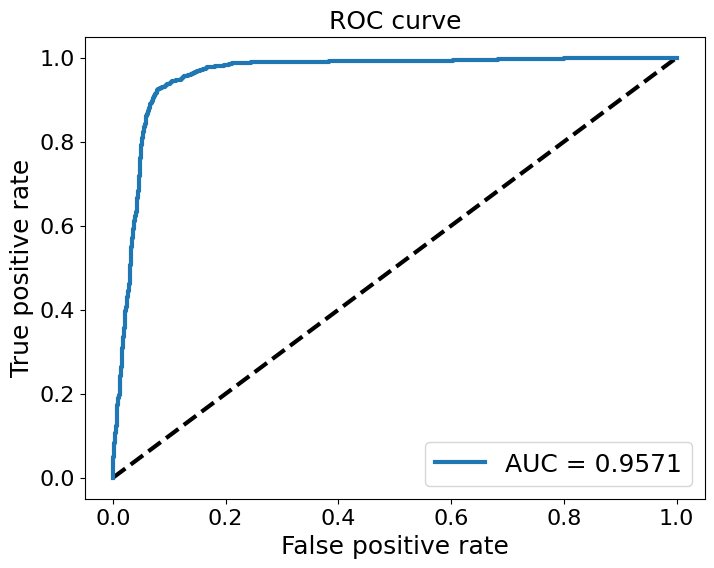

Confusion matrix, without normalization
[[4247  199]
 [ 412  863]]


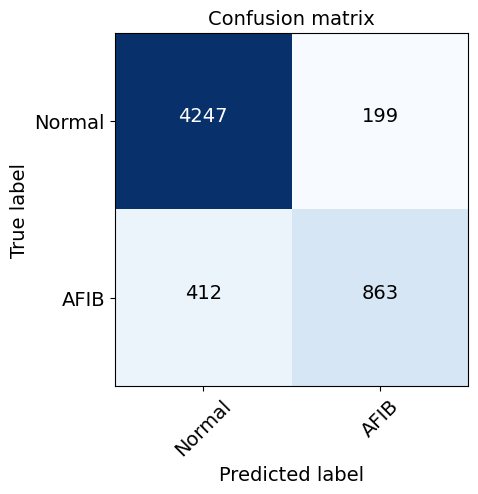

appended metrics
(116949, 3000, 1)
(116949, 2)
shape of y: (116949, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116949, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1828/1828 [==============================] - 66s 36ms/step - loss: 0.0240 - accuracy: 0.9922 - val_loss: 0.0401 - val_accuracy: 0.9916
Epoch 2/25
1828/1828 [==============================] - 66s 36ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.2960 - val_accuracy: 0.8736
Epoch 3/25
1828/1828 [==============================] - 66s 36ms/step - loss: 0.0204 - accuracy: 0.9935 - val_loss: 0.1066 - val_accuracy: 0.9611
Epoch 4/25
1828/1828 [==============================] - 66s 36ms/step - loss: 0.0344 - accuracy: 0.9889 - val_loss: 0.4496 - val_accuracy: 0.8000
Epoch 5/25
1828/1828 [==============================] - 66s 36ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.4349 - val_accuracy: 0.7974
Epoch 6/25
1828/1828 [==============================] - 67s 36ms/step - loss: 0.0307 - accuracy: 

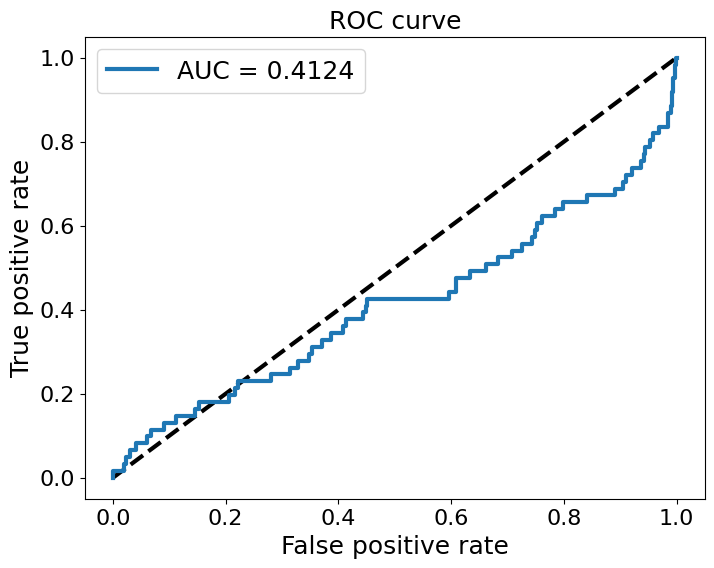

Confusion matrix, without normalization
[[ 984 4429]
 [  21   40]]


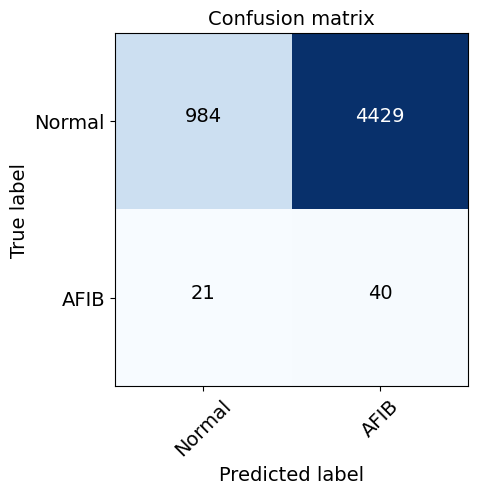

appended metrics
(116830, 3000, 1)
(116830, 2)
shape of y: (116830, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116830, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.5576 - accuracy: 0.7023 - val_loss: 0.6175 - val_accuracy: 0.6674
Epoch 2/25
1826/1826 [==============================] - 65s 36ms/step - loss: 0.5565 - accuracy: 0.7033 - val_loss: 0.5791 - val_accuracy: 0.7229
Epoch 3/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.5570 - accuracy: 0.7024 - val_loss: 0.5711 - val_accuracy: 0.7542
Epoch 4/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.5577 - accuracy: 0.7017 - val_loss: 0.6219 - val_accuracy: 0.6769
Epoch 5/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.5566 - accuracy: 0.7044 - val_loss: 0.6432 - val_accuracy: 0.6408
Epoch 6/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.5563 - accuracy: 

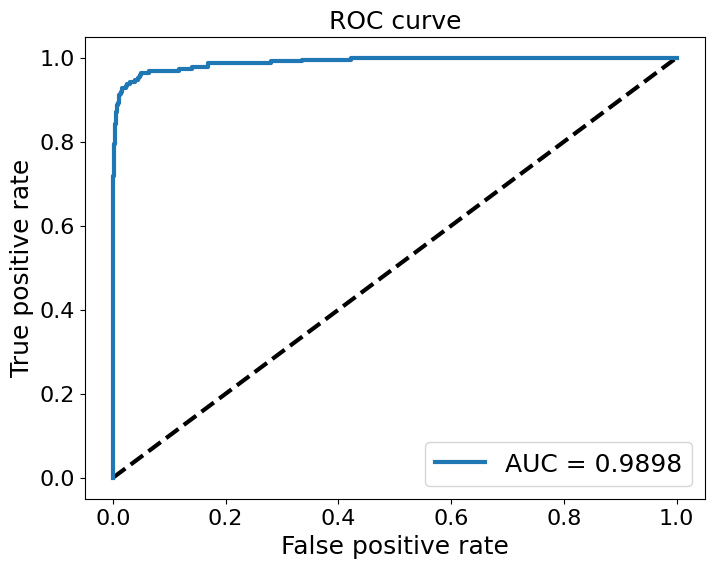

Confusion matrix, without normalization
[[4964  406]
 [   7  216]]


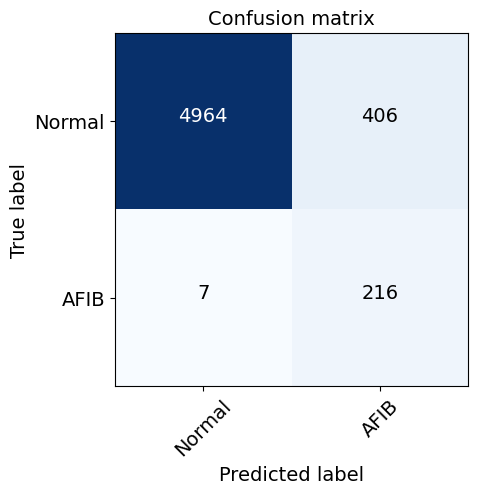

appended metrics
(116796, 3000, 1)
(116796, 2)
shape of y: (116796, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116796, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.5743 - accuracy: 0.6941 - val_loss: 0.8806 - val_accuracy: 0.4505
Epoch 2/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.5931 - accuracy: 0.6880 - val_loss: 0.7872 - val_accuracy: 0.4777
Epoch 3/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.5856 - accuracy: 0.7017 - val_loss: 0.8114 - val_accuracy: 0.4578
Epoch 4/25
1825/1825 [==============================] - 65s 36ms/step - loss: 0.5963 - accuracy: 0.6896 - val_loss: 0.7829 - val_accuracy: 0.4443
Epoch 5/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.6098 - accuracy: 0.6718 - val_loss: 0.8415 - val_accuracy: 0.3920
Epoch 6/25
1825/1825 [==============================] - 65s 36ms/step - loss: 0.6484 - accuracy: 

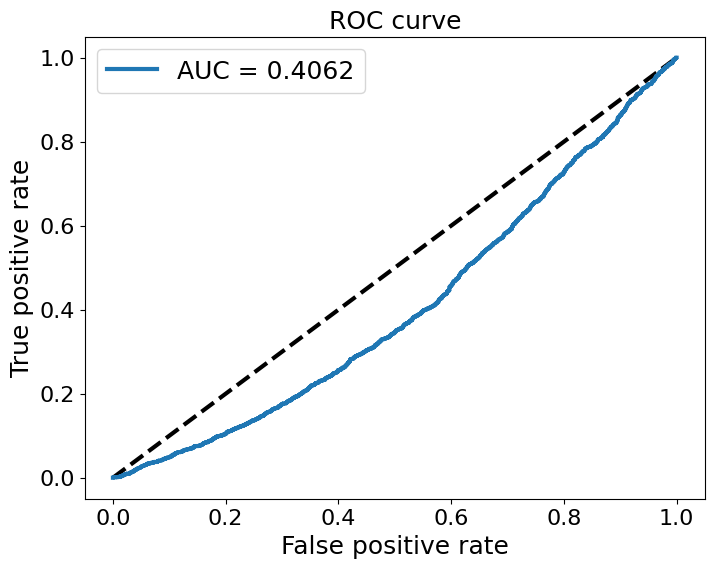

Confusion matrix, without normalization
[[1856  682]
 [2620  469]]


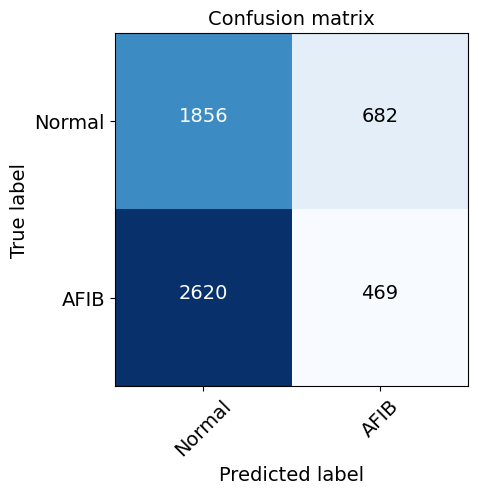

appended metrics
(116749, 3000, 1)
(116749, 2)
shape of y: (116749, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116749, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.6455 - accuracy: 0.6296 - val_loss: 0.6962 - val_accuracy: 0.5437
Epoch 2/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.6445 - accuracy: 0.6293 - val_loss: 0.6681 - val_accuracy: 0.5911
Epoch 3/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.6485 - accuracy: 0.6262 - val_loss: 0.7998 - val_accuracy: 0.5032
Epoch 4/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.6518 - accuracy: 0.6239 - val_loss: 0.7729 - val_accuracy: 0.5229
Epoch 5/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.6504 - accuracy: 0.6266 - val_loss: 0.7402 - val_accuracy: 0.5162
Epoch 6/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.6457 - accuracy: 

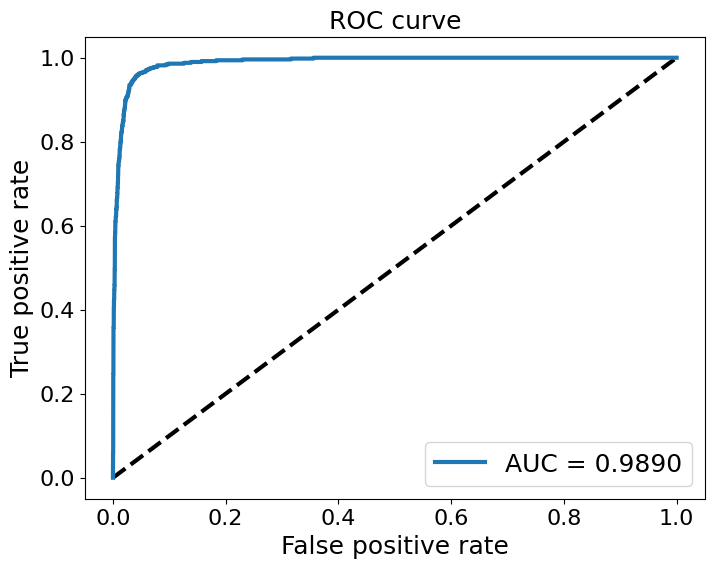

Confusion matrix, without normalization
[[4072 1107]
 [   3  492]]


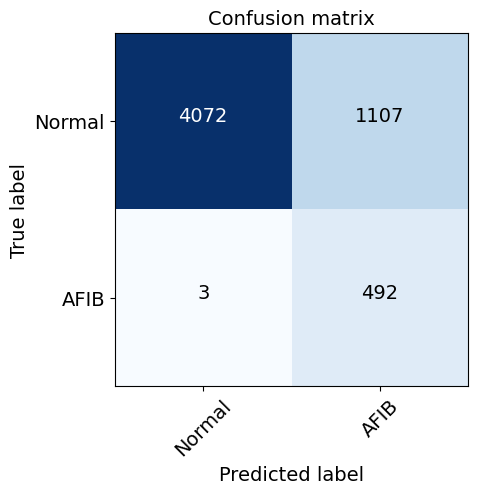

appended metrics
(117177, 3000, 1)
(117177, 2)
shape of y: (117177, 2), type of y: <class 'numpy.ndarray'>
shape of x: (117177, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1831/1831 [==============================] - 66s 36ms/step - loss: 0.0433 - accuracy: 0.9871 - val_loss: 0.1191 - val_accuracy: 0.9565
Epoch 2/25
1831/1831 [==============================] - 67s 36ms/step - loss: 0.0417 - accuracy: 0.9878 - val_loss: 0.9602 - val_accuracy: 0.7307
Epoch 3/25
1831/1831 [==============================] - 66s 36ms/step - loss: 0.0441 - accuracy: 0.9873 - val_loss: 0.6081 - val_accuracy: 0.7995
Epoch 4/25
1831/1831 [==============================] - 66s 36ms/step - loss: 0.0346 - accuracy: 0.9898 - val_loss: 0.6280 - val_accuracy: 0.7907
Epoch 5/25
1831/1831 [==============================] - 67s 36ms/step - loss: 0.0358 - accuracy: 0.9897 - val_loss: 0.5932 - val_accuracy: 0.8496
Epoch 6/25
1831/1831 [==============================] - 67s 36ms/step - loss: 0.0299 - accuracy: 

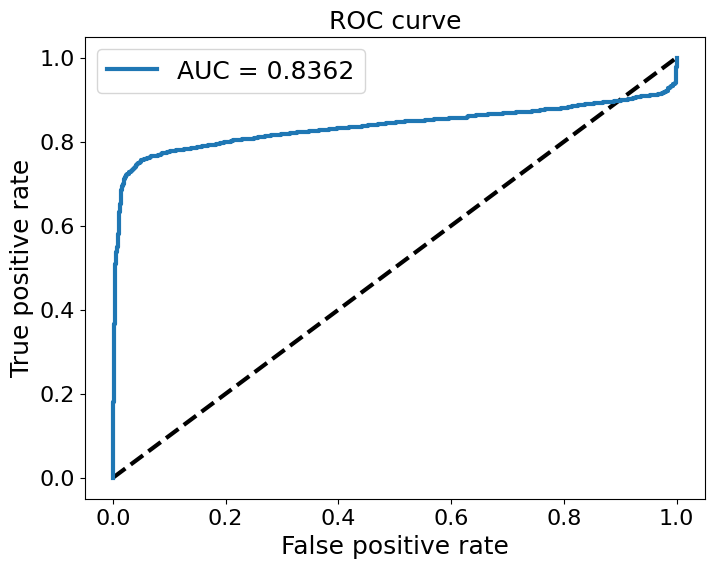

Confusion matrix, without normalization
[[1056   12]
 [1558 2620]]


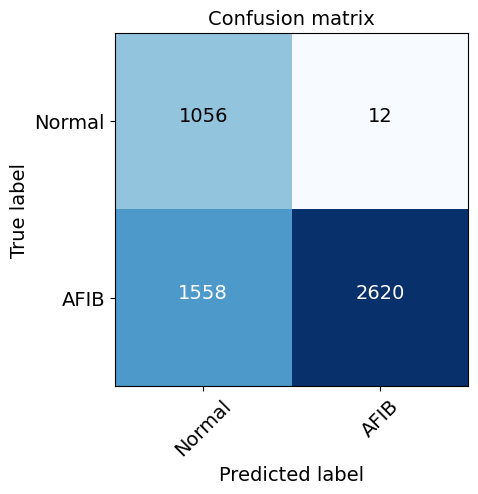

appended metrics
(116902, 3000, 1)
(116902, 2)
shape of y: (116902, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116902, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1827/1827 [==============================] - 66s 36ms/step - loss: 0.0356 - accuracy: 0.9888 - val_loss: 0.0686 - val_accuracy: 0.9710
Epoch 2/25
1827/1827 [==============================] - 65s 36ms/step - loss: 0.0277 - accuracy: 0.9915 - val_loss: 0.0199 - val_accuracy: 0.9937
Epoch 3/25
1827/1827 [==============================] - 66s 36ms/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 0.0275 - val_accuracy: 0.9897
Epoch 4/25
1827/1827 [==============================] - 66s 36ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.0506 - val_accuracy: 0.9790
Epoch 5/25
1827/1827 [==============================] - 66s 36ms/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 0.1249 - val_accuracy: 0.9533
Epoch 6/25
1827/1827 [==============================] - 65s 36ms/step - loss: 0.0261 - accuracy: 

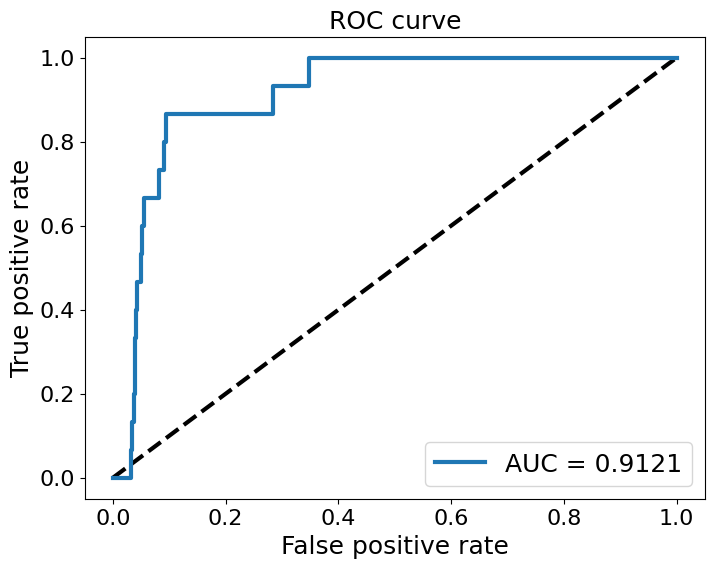

Confusion matrix, without normalization
[[5307  199]
 [  13    2]]


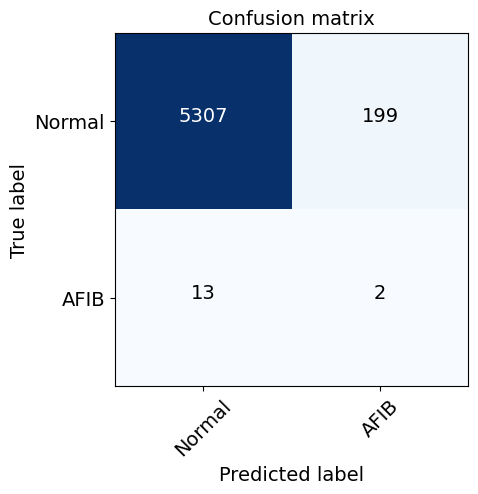

appended metrics
(116805, 3000, 1)
(116805, 2)
shape of y: (116805, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116805, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.0279 - accuracy: 0.9920 - val_loss: 0.2914 - val_accuracy: 0.9347
Epoch 2/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.0245 - accuracy: 0.9929 - val_loss: 0.2260 - val_accuracy: 0.9375
Epoch 3/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.3012 - accuracy: 0.8653 - val_loss: 0.5187 - val_accuracy: 0.8021
Epoch 4/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.2253 - accuracy: 0.9100 - val_loss: 0.2908 - val_accuracy: 0.8896
Epoch 5/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.1528 - accuracy: 0.9424 - val_loss: 0.2792 - val_accuracy: 0.9167
Epoch 6/25
1826/1826 [==============================] - 66s 36ms/step - loss: 0.1036 - accuracy: 

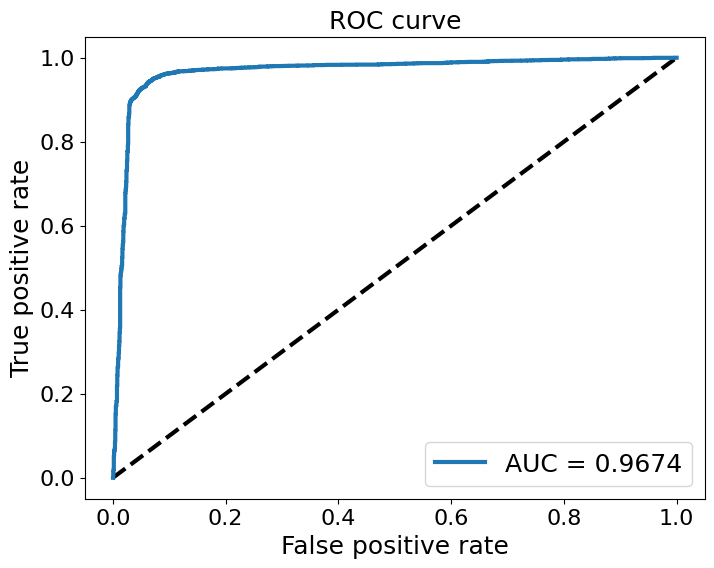

Confusion matrix, without normalization
[[1867   97]
 [ 270 3384]]


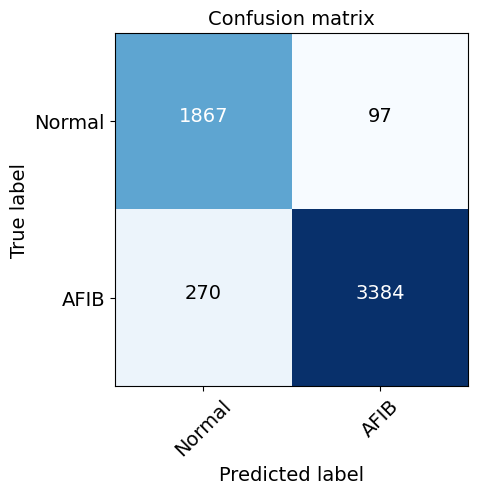

appended metrics
(116800, 3000, 1)
(116800, 2)
shape of y: (116800, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116800, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.0331 - accuracy: 0.9911 - val_loss: 0.0120 - val_accuracy: 0.9975
Epoch 2/25
1825/1825 [==============================] - 67s 37ms/step - loss: 0.0312 - accuracy: 0.9913 - val_loss: 0.0218 - val_accuracy: 0.9947
Epoch 3/25
1825/1825 [==============================] - 67s 37ms/step - loss: 0.0329 - accuracy: 0.9909 - val_loss: 0.0122 - val_accuracy: 0.9970
Epoch 4/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.0293 - accuracy: 0.9918 - val_loss: 0.0081 - val_accuracy: 0.9980
Epoch 5/25
1825/1825 [==============================] - 67s 37ms/step - loss: 0.0286 - accuracy: 0.9917 - val_loss: 0.0123 - val_accuracy: 0.9963
Epoch 6/25
1825/1825 [==============================] - 66s 36ms/step - loss: 0.0269 - accuracy: 

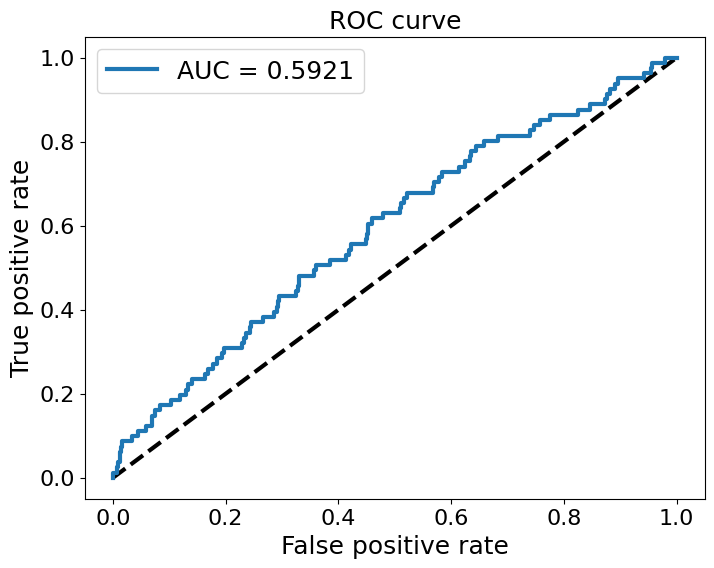

Confusion matrix, without normalization
[[3738 1804]
 [  45   36]]


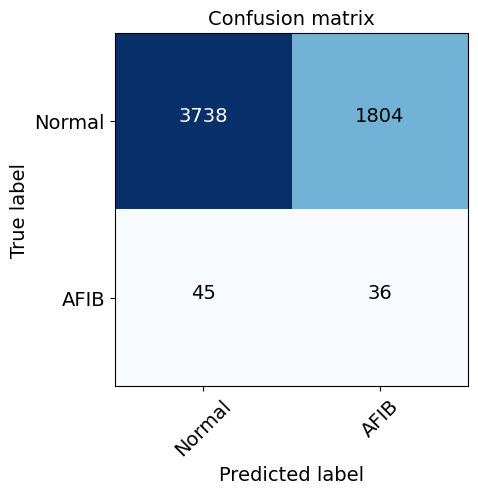

appended metrics
(116786, 3000, 1)
(116786, 2)
shape of y: (116786, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116786, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.6467 - val_loss: nan - val_accuracy: 0.0399
Epoch 2/25
1825/1825 [==============================] - 62s 34ms/step - loss: nan - accuracy: 0.6033 - val_loss: nan - val_accuracy: 0.0399
Epoch 3/25
1825/1825 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.6033 - val_loss: nan - val_accuracy: 0.0399
Epoch 4/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.6033 - val_loss: nan - val_accuracy: 0.0399
Epoch 5/25
1825/1825 [==============================] - 57s 31ms/step - loss: nan - accuracy: 0.6033 - val_loss: nan - val_accuracy: 0.0399
Epoch 6/25
1825/1825 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.6033 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


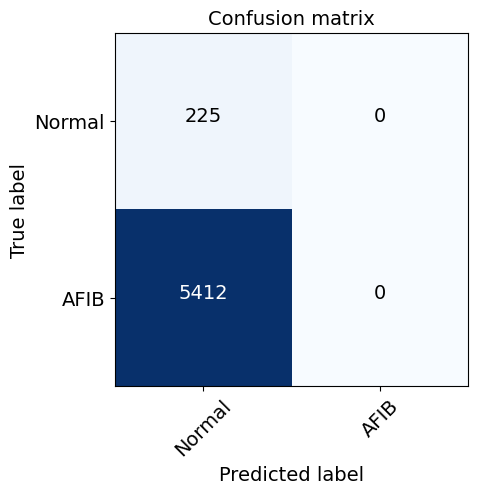

appended metrics
(117368, 3000, 1)
(117368, 2)
shape of y: (117368, 2), type of y: <class 'numpy.ndarray'>
shape of x: (117368, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1834/1834 [==============================] - 67s 37ms/step - loss: nan - accuracy: 0.5597 - val_loss: nan - val_accuracy: 0.9883
Epoch 2/25
1834/1834 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5597 - val_loss: nan - val_accuracy: 0.9883
Epoch 3/25
1834/1834 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5597 - val_loss: nan - val_accuracy: 0.9883
Epoch 4/25
1834/1834 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5597 - val_loss: nan - val_accuracy: 0.9883
Epoch 5/25
1834/1834 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5597 - val_loss: nan - val_accuracy: 0.9883
Epoch 6/25
1834/1834 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5597 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


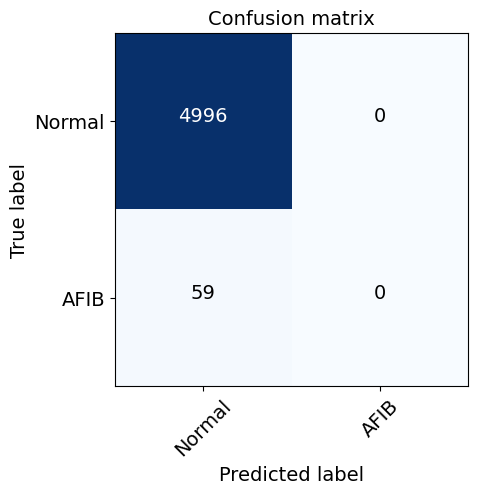

appended metrics
(116747, 3000, 1)
(116747, 2)
shape of y: (116747, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116747, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5793 - val_loss: nan - val_accuracy: 0.5381
Epoch 2/25
1825/1825 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5793 - val_loss: nan - val_accuracy: 0.5381
Epoch 3/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5793 - val_loss: nan - val_accuracy: 0.5381
Epoch 4/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5793 - val_loss: nan - val_accuracy: 0.5381
Epoch 5/25
1825/1825 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5793 - val_loss: nan - val_accuracy: 0.5381
Epoch 6/25
1825/1825 [==============================] - 67s 36ms/step - loss: nan - accuracy: 0.5793 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


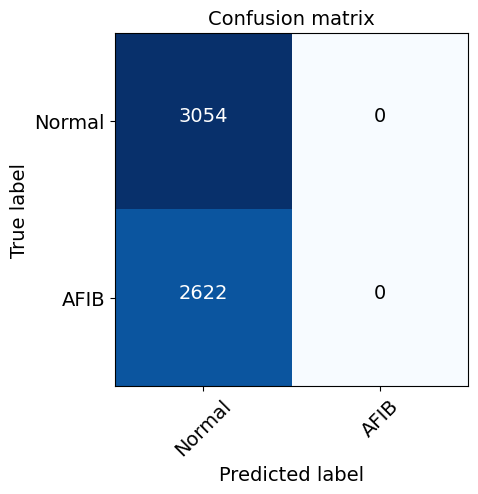

appended metrics
(116870, 3000, 1)
(116870, 2)
shape of y: (116870, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116870, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1827/1827 [==============================] - 67s 37ms/step - loss: nan - accuracy: 0.6048 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/25
1827/1827 [==============================] - 67s 36ms/step - loss: nan - accuracy: 0.6048 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/25
1827/1827 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.6048 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/25
1827/1827 [==============================] - 67s 36ms/step - loss: nan - accuracy: 0.6048 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/25
1827/1827 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.6048 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/25
1827/1827 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.6048 - val_

/tmp/ipykernel_250/3188083228.py:27: RuntimeWarning: invalid value encountered in long_scalars
  tnr = tn/(tn+fp)
/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)
/tmp/ipykernel_250/3188083228.py:31: RuntimeWarning: invalid value encountered in long_scalars
  fpr = fp/(tn+fp)


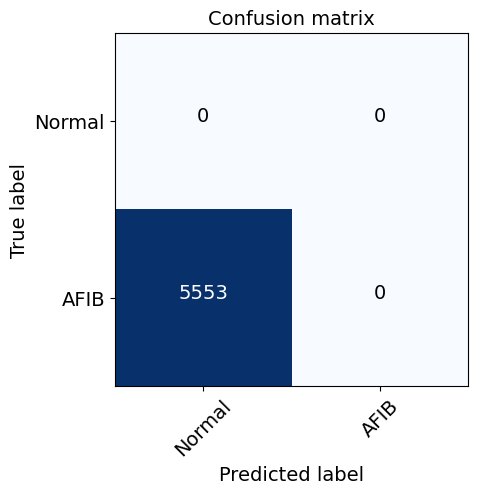

appended metrics
(116713, 3000, 1)
(116713, 2)
shape of y: (116713, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116713, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.6056 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.6056 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.6056 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.6056 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.6056 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.6056 - val_

/tmp/ipykernel_250/3188083228.py:27: RuntimeWarning: invalid value encountered in long_scalars
  tnr = tn/(tn+fp)
/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)
/tmp/ipykernel_250/3188083228.py:31: RuntimeWarning: invalid value encountered in long_scalars
  fpr = fp/(tn+fp)


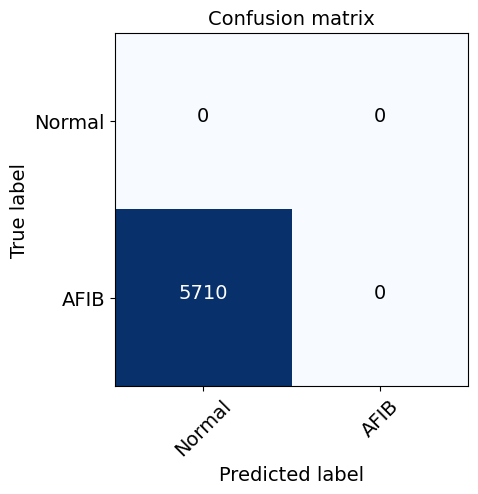

appended metrics
(116752, 3000, 1)
(116752, 2)
shape of y: (116752, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116752, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1825/1825 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5870 - val_loss: nan - val_accuracy: 0.3781
Epoch 2/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5870 - val_loss: nan - val_accuracy: 0.3781
Epoch 3/25
1825/1825 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5870 - val_loss: nan - val_accuracy: 0.3781
Epoch 4/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5870 - val_loss: nan - val_accuracy: 0.3781
Epoch 5/25
1825/1825 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5870 - val_loss: nan - val_accuracy: 0.3781
Epoch 6/25
1825/1825 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5870 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


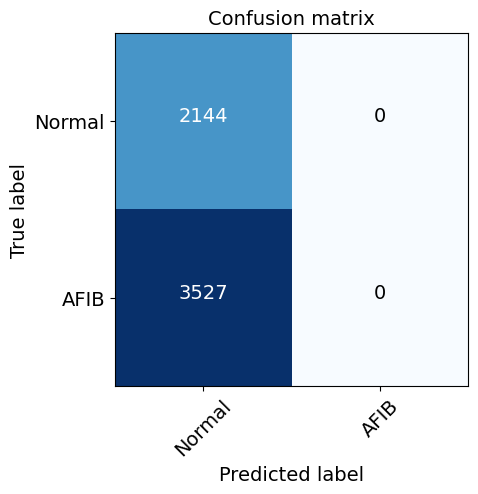

appended metrics
(117029, 3000, 1)
(117029, 2)
shape of y: (117029, 2), type of y: <class 'numpy.ndarray'>
shape of x: (117029, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1829/1829 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5646 - val_loss: nan - val_accuracy: 0.8537
Epoch 2/25
1829/1829 [==============================] - 65s 35ms/step - loss: nan - accuracy: 0.5646 - val_loss: nan - val_accuracy: 0.8537
Epoch 3/25
1829/1829 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5646 - val_loss: nan - val_accuracy: 0.8537
Epoch 4/25
1829/1829 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5646 - val_loss: nan - val_accuracy: 0.8537
Epoch 5/25
1829/1829 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5646 - val_loss: nan - val_accuracy: 0.8537
Epoch 6/25
1829/1829 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5646 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


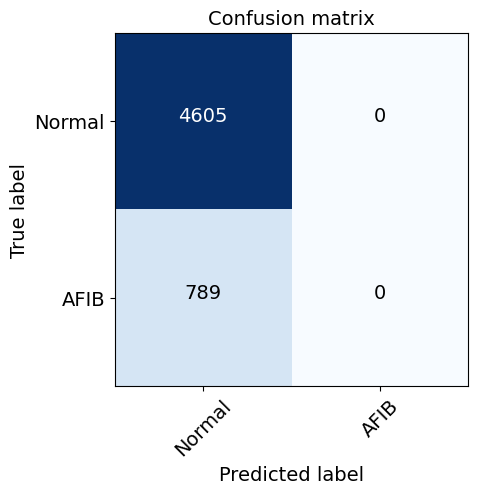

appended metrics
(116854, 3000, 1)
(116854, 2)
shape of y: (116854, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116854, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1826/1826 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5955 - val_loss: nan - val_accuracy: 0.1966
Epoch 2/25
1826/1826 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5955 - val_loss: nan - val_accuracy: 0.1966
Epoch 3/25
1826/1826 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5955 - val_loss: nan - val_accuracy: 0.1966
Epoch 4/25
1826/1826 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5955 - val_loss: nan - val_accuracy: 0.1966
Epoch 5/25
1826/1826 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5955 - val_loss: nan - val_accuracy: 0.1966
Epoch 6/25
1826/1826 [==============================] - 67s 37ms/step - loss: nan - accuracy: 0.5955 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


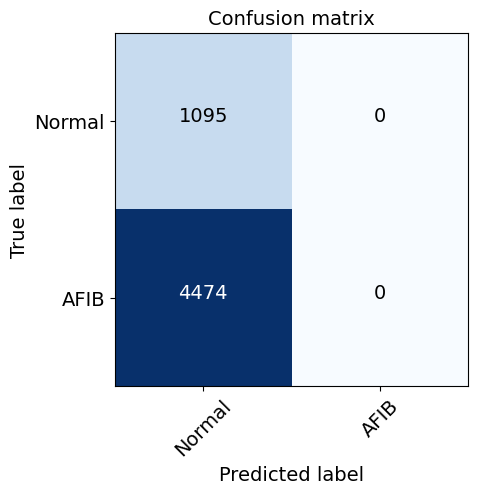

appended metrics
(116707, 3000, 1)
(116707, 2)
shape of y: (116707, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116707, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5676 - val_loss: nan - val_accuracy: 0.7775
Epoch 2/25
1824/1824 [==============================] - 65s 35ms/step - loss: nan - accuracy: 0.5676 - val_loss: nan - val_accuracy: 0.7775
Epoch 3/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5676 - val_loss: nan - val_accuracy: 0.7775
Epoch 4/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5676 - val_loss: nan - val_accuracy: 0.7775
Epoch 5/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5676 - val_loss: nan - val_accuracy: 0.7775
Epoch 6/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5676 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


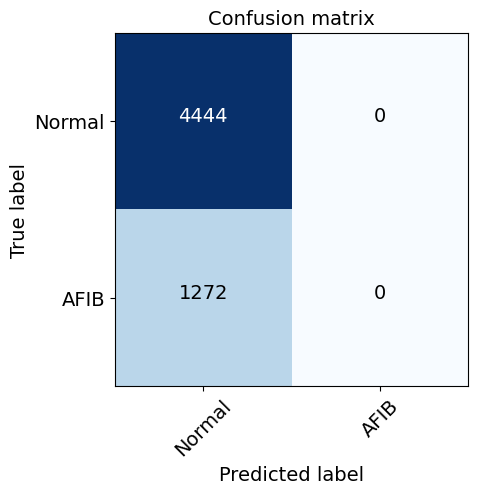

appended metrics
(117050, 3000, 1)
(117050, 2)
shape of y: (117050, 2), type of y: <class 'numpy.ndarray'>
shape of x: (117050, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1829/1829 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5683 - val_loss: nan - val_accuracy: 0.7742
Epoch 2/25
1829/1829 [==============================] - 67s 36ms/step - loss: nan - accuracy: 0.5683 - val_loss: nan - val_accuracy: 0.7742
Epoch 3/25
1829/1829 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5683 - val_loss: nan - val_accuracy: 0.7742
Epoch 4/25
1829/1829 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5683 - val_loss: nan - val_accuracy: 0.7742
Epoch 5/25
1829/1829 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5683 - val_loss: nan - val_accuracy: 0.7742
Epoch 6/25
1829/1829 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5683 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


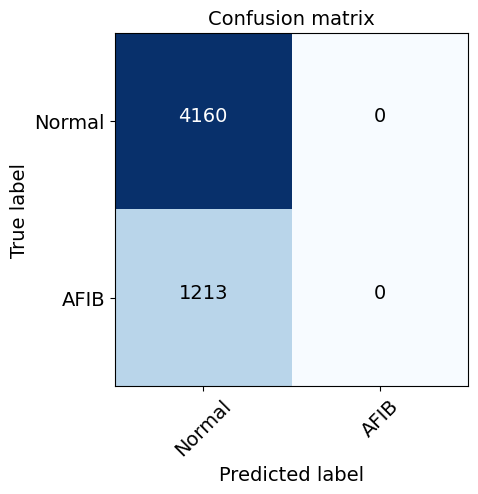

appended metrics
(116718, 3000, 1)
(116718, 2)
shape of y: (116718, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116718, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5917 - val_loss: nan - val_accuracy: 0.2840
Epoch 2/25
1824/1824 [==============================] - 67s 37ms/step - loss: nan - accuracy: 0.5917 - val_loss: nan - val_accuracy: 0.2840
Epoch 3/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5917 - val_loss: nan - val_accuracy: 0.2840
Epoch 4/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5917 - val_loss: nan - val_accuracy: 0.2840
Epoch 5/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5917 - val_loss: nan - val_accuracy: 0.2840
Epoch 6/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5917 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


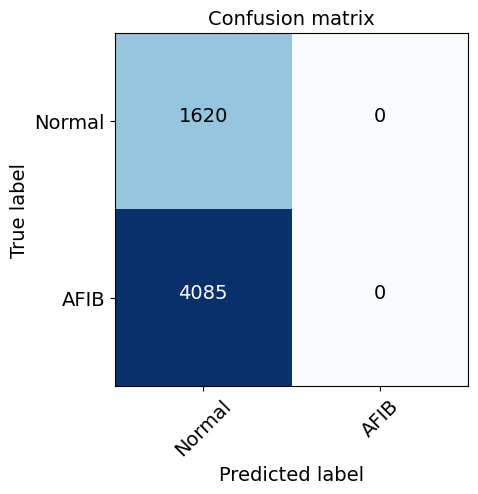

appended metrics
(116696, 3000, 1)
(116696, 2)
shape of y: (116696, 2), type of y: <class 'numpy.ndarray'>
shape of x: (116696, 3000, 1), type of y: <class 'numpy.ndarray'>
Epoch 1/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5902 - val_loss: nan - val_accuracy: 0.3164
Epoch 2/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5902 - val_loss: nan - val_accuracy: 0.3164
Epoch 3/25
1824/1824 [==============================] - 65s 36ms/step - loss: nan - accuracy: 0.5902 - val_loss: nan - val_accuracy: 0.3164
Epoch 4/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5902 - val_loss: nan - val_accuracy: 0.3164
Epoch 5/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5902 - val_loss: nan - val_accuracy: 0.3164
Epoch 6/25
1824/1824 [==============================] - 66s 36ms/step - loss: nan - accuracy: 0.5902 - val_loss: nan - val_accu

/tmp/ipykernel_250/3188083228.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)


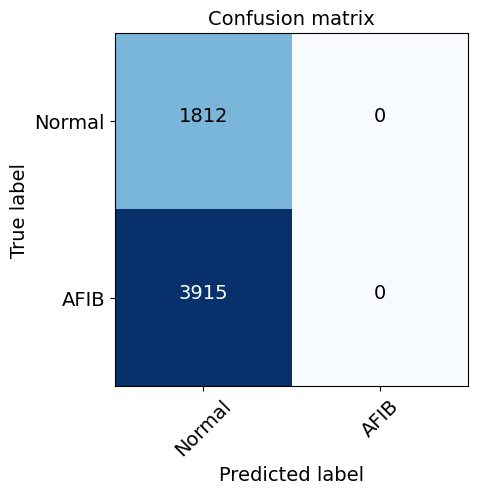

appended metrics


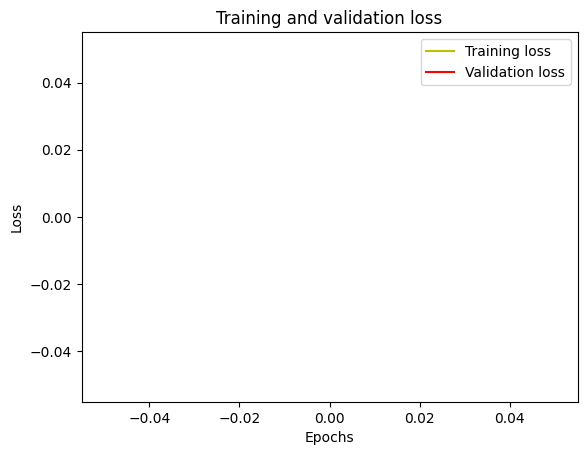

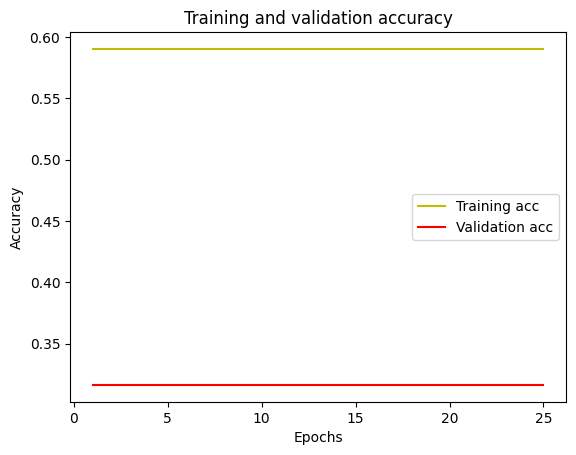

In [10]:
combo = buildBest1603()

logoloop(combo)


In [45]:
results = pd.read_pickle(startdir+"/results/logo_metrics.pkl")  
results
   

,model,acc,tpr,tnr,prec,fpr,roc_auc,f1,time
0,04015,0.922383,0.153846,0.927831,0.014888,0.072169,0.663273,0.027149,22.365640
0,04043,0.560392,0.378039,0.612686,0.218693,0.387314,0.499495,0.277091,18.965135
0,04048,0.028864,0.557377,0.022908,0.006387,0.977092,0.141917,0.012630,18.588324
0,04126,0.044878,0.713004,0.017132,0.029244,0.982868,0.111321,0.056184,18.957065
0,04746,0.548960,1.000000,0.000000,0.548960,1.000000,0.503938,0.708811,18.507675
0,04908,0.912584,0.000000,0.999807,0.000000,0.000193,0.530604,0.000000,19.124555
0,04936,0.203584,0.000000,1.000000,NaN,0.000000,0.615835,0.000000,18.208618
0,05091,0.996015,0.000000,0.998729,0.000000,0.001271,0.538382,0.000000,18.827058
0,05121,0.646849,0.888615,0.197047,0.673093,0.802953,0.574349,0.765983,18.654998
0,05261,0.706740,0.679012,0.707145,0.032777,0.292855,0.767735,0.062536,19.198084


In [15]:
toappend = evaluate(X_test,y_test, model, "combo", time)

metrics = pd.concat([metrics, toappend])
print("appended metrics")

losscurve(history)
acccurve(history)
metrics.to_pickle('metrics')

NameError: name 'X_test' is not defined

In [27]:

split_train_eval(combo)

[ 105889  105890  105891 ... 1116496 1116497 1116498]
[     0      1      2 ... 856985 856986 856987]
<generator object BaseShuffleSplit.split at 0x7f9e8b30ac70>


# Cut below and insert potentially as separate setup file

In [29]:
# https://www.sciencedirect.com/science/article/pii/S1746809420303323#fig0020

#workaround to be able to declare model prior to splitting data like in LOGO or CV.
X_train = np.zeros((3, X.shape[1],1))


combo = keras.models.Sequential([
    keras.layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu',
                        input_shape=[X_train.shape[1], X_train.shape[2]],name='conv1'),
    keras.layers.BatchNormalization(name='batch1'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool1'),
    keras.layers.Conv1D(filters = 64 , kernel_size = 5, activation = 'relu',name='conv2'),
    keras.layers.BatchNormalization(name='batch2'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool2'),
    keras.layers.Conv1D(filters = 32 , kernel_size = 5, activation = 'relu',name='conv3'),
    keras.layers.BatchNormalization(name='batch3'),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool3' ),
    keras.layers.LSTM(64, return_sequences=False, name='LSTM'), 
    keras.layers.Dense(128,  name='dense_1'),
    keras.layers.Dense(2, activation='sigmoid', name='dense_2'),
    
])
                              
combo.summary()

#use? https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryFocalCrossentropy

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 1496, 32)          192       
                                                                 
 batch1 (BatchNormalization)  (None, 1496, 32)         128       
                                                                 
 max_pool1 (MaxPooling1D)    (None, 748, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 744, 64)           10304     
                                                                 
 batch2 (BatchNormalization)  (None, 744, 64)          256       
                                                                 
 max_pool2 (MaxPooling1D)    (None, 372, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 368, 32)         

In [4]:
##TWO-LAYERD LSTM for masters
lstm2 = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True, 
                      input_shape=[X_train.shape[1], X_train.shape[2]], name='rnn_1'),
    keras.layers.Dropout(rate = 0.2, name='dropout_1'),
    keras.layers.LSTM(64, return_sequences=False, name='rnn_2'),
    keras.layers.Dropout(rate = 0.2, name='dropout_2'),
    keras.layers.Dense(2,  name='dense_1'),
    keras.layers.Dense(2, activation='sigmoid', name='dense_2'),
    #keras.layers.Flatten()
])
lstm2.summary()


NameError: name 'X_train' is not defined

In [ ]:
#redundant only to use if not entire notebook is run from start.
patients = ['04015','04043','04048','04126','04746','04908',
            '04936','05091','05121','05261','06426','06453','06995','07162',
            '07859','07879','07910','08215','08219','08378','08405','08434',
            '08455']

def makesplit():

#Change to dataframe to allow for slicing below
ids = pd.DataFrame({'id':ids})
X = pd.DataFrame(X)
y = pd.DataFrame(y)

#make test and train split (16/7)
#change to use groupKsplit eventually
pts_train = random.sample(patients, 16)
pts_valid = [pt for pt in patients if pt not in pts_train]

print(pts_train)
print(pts_valid)

X_train = (X.loc[ids.id.isin(pts_train)]).to_numpy()
X_valid = (X.loc[ids.id.isin(pts_valid)]).to_numpy()
y_train = (y.loc[ids.id.isin(pts_train)]).to_numpy()
y_valid = (y.loc[ids.id.isin(pts_valid)]).to_numpy()

#reshape data: 
# reshape input to be [samples, time steps, features = 1]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
#X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#print(X_test.shape)
print(X_train.shape)
print(X_valid.shape)
    

In [13]:
to_append = pd.read_pickle("./data/afdb/flt_ol5_win4/metrics.pkl")  
to_append

,model,acc,tpr,tnr,prec,fpr,roc_auc,f1,time
0,combo,0.845028,0.655045,0.971723,0.939203,0.028277,0.055006,0.7718,0 days 00:17:29.658282


In [24]:
import time

t0 = time.time()
wait()
print('hello')
print(round(time.time() - t0)), "seconds wall time")

minutes = (seconds % 3600) // 60
seconds = seconds % 60

hello
0.0002827644348144531 seconds wall time
